## Customer Churn Prediction

#### About dataset

- **RowNumber** —corresponds to the record (row) number and has no effect on the output.
- **CustomerId** —contains random values and has no effect on customer leaving the bank.
- **Surname** —the surname of a customer has no impact on their decision to leave the bank.
- **CreditScore** —can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- **Geography** —a customer’s location can affect their decision to leave the bank.
- **Gender** —it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age**—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure**—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
- **Balance**—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- **NumOfProducts**—refers to the number of products that a customer has purchased through the bank.
- **HasCrCard**—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- **IsActiveMember**—active customers are less likely to leave the bank.
- **EstimatedSalary**—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited**—whether or not the customer left the bank.
- **Complain**—customer has complaint or not.
- **Satisfaction Score**—Score provided by the customer for their complaint resolution.
- **Card Type**—type of card hold by the customer.
- **Points Earned**—the points earned by the customer for using credit card.


In [398]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import math 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
from scipy.stats import norm, skew 
from scipy import stats

In [399]:
bank_churn = pd.read_csv("Customer-Churn-Records.csv")

In [400]:
bank_churn

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0           101348.88       1         1                   2   DIAMOND   
1           112542.58       0         1                   3   DIAMOND   
2           113931.57       1         1                   3   DIAMOND   
3            93826.63       0         0                   5      GOLD   
4            79084.10       0         0                   5      GOLD   
...               ...     ...       ...                 ...       ...   
9995         96270.64       0         0                   1   DIAMOND   
9996        101699.77       0         0                   5  PLATINUM   
9997         42085.58       1         1                   3    SILVER   
9998         92888.52       1         1                   2      GOLD   
9999         38190.78       0         0                   3   DIAMOND   

      Point Earned  
0              464  
1              456  
2              377  
3              350  
4              425  
...            ...  
9995           300  
9996           771  
9997           564  
9998           339  
9999           911  

[10000 rows x 18 columns]

## EDA

1. Data profile

In [401]:
# Changing target name from exited to churn and positioning it at the end for better understanding
bank_churn['Churn'] = bank_churn.pop('Exited')

In [402]:
def data_profile(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary

data_profile(bank_churn)

Dataset Shape: (10000, 18)


Name   dtypes  Missing  Uniques Sample Value  Entropy
0            RowNumber    int64        0    10000            1     4.00
1           CustomerId    int64        0    10000     15634602     4.00
2              Surname   object        0     2932     Hargrave     3.23
3          CreditScore    int64        0      460          619     2.55
4            Geography   object        0        3       France     0.45
5               Gender   object        0        2       Female     0.30
6                  Age    int64        0       70           42     1.60
7               Tenure    int64        0       11            2     1.03
8              Balance  float64        0     6382          0.0     2.71
9        NumOfProducts    int64        0        4            1     0.36
10           HasCrCard    int64        0        2            1     0.26
11      IsActiveMember    int64        0        2            1     0.30
12     EstimatedSalary  float64        0     9999    101348.88     4.00
13            Complain    int64        0        2            1     0.22
14  Satisfaction Score    int64        0        5            2     0.70
15           Card Type   object        0        4      DIAMOND     0.60
16        Point Earned    int64        0      785          464     2.88
17               Churn    int64        0        2            1     0.22

Action
- Remove RowNumber, CustomerID and Surname as it is unique for every row and wont be used in prediction. 
- Use label encoder for columns having 2 unique values, except for Gender every other such column is already encoded.

In [403]:
# Dropping RowNumber, CustomerID & Surname
cust = bank_churn.iloc[:,3:].copy()

In [404]:
#Label Encoding for Gender
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cust['Gender'] = le.fit_transform(cust.Gender.values)

2. Handling missing values

We dont have any missing values. So we can move to the next step

3. Churn rate

In [405]:
print("Customer Churn Rate(%):")
print(round(cust['Churn'].value_counts(normalize=True) * 100,2))

Customer Churn Rate(%):
0    79.62
1    20.38
Name: Churn, dtype: float64


## Analyzing and preprocessing

#### a. Identifying correlation with Churn

- Converting all categorical values to dummy variables (Geography, Card Type)

In [406]:
cust_dummies = pd.get_dummies(cust)

<Axes: >

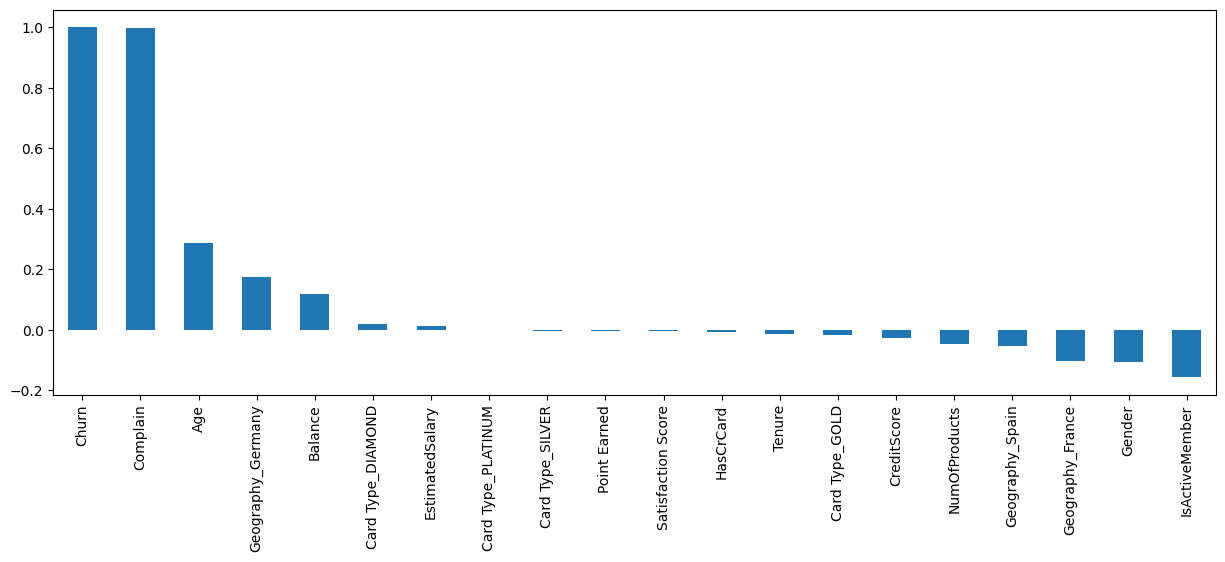

In [407]:
plt.figure(figsize=(15,5))
cust_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

##### Observation
- Age and Estimated Salary are positively correlated to Churn. Obviously, Complain has high positive correlation with Churn.
- Surprisingly Balance is also positively correlated to churn, which means even customers with higher balance are likely to exit bank.
- CreditScore, NumberOfProducts and ActiveMember are negatively related to Churn.

#### b. Analyzing Numerical Variables

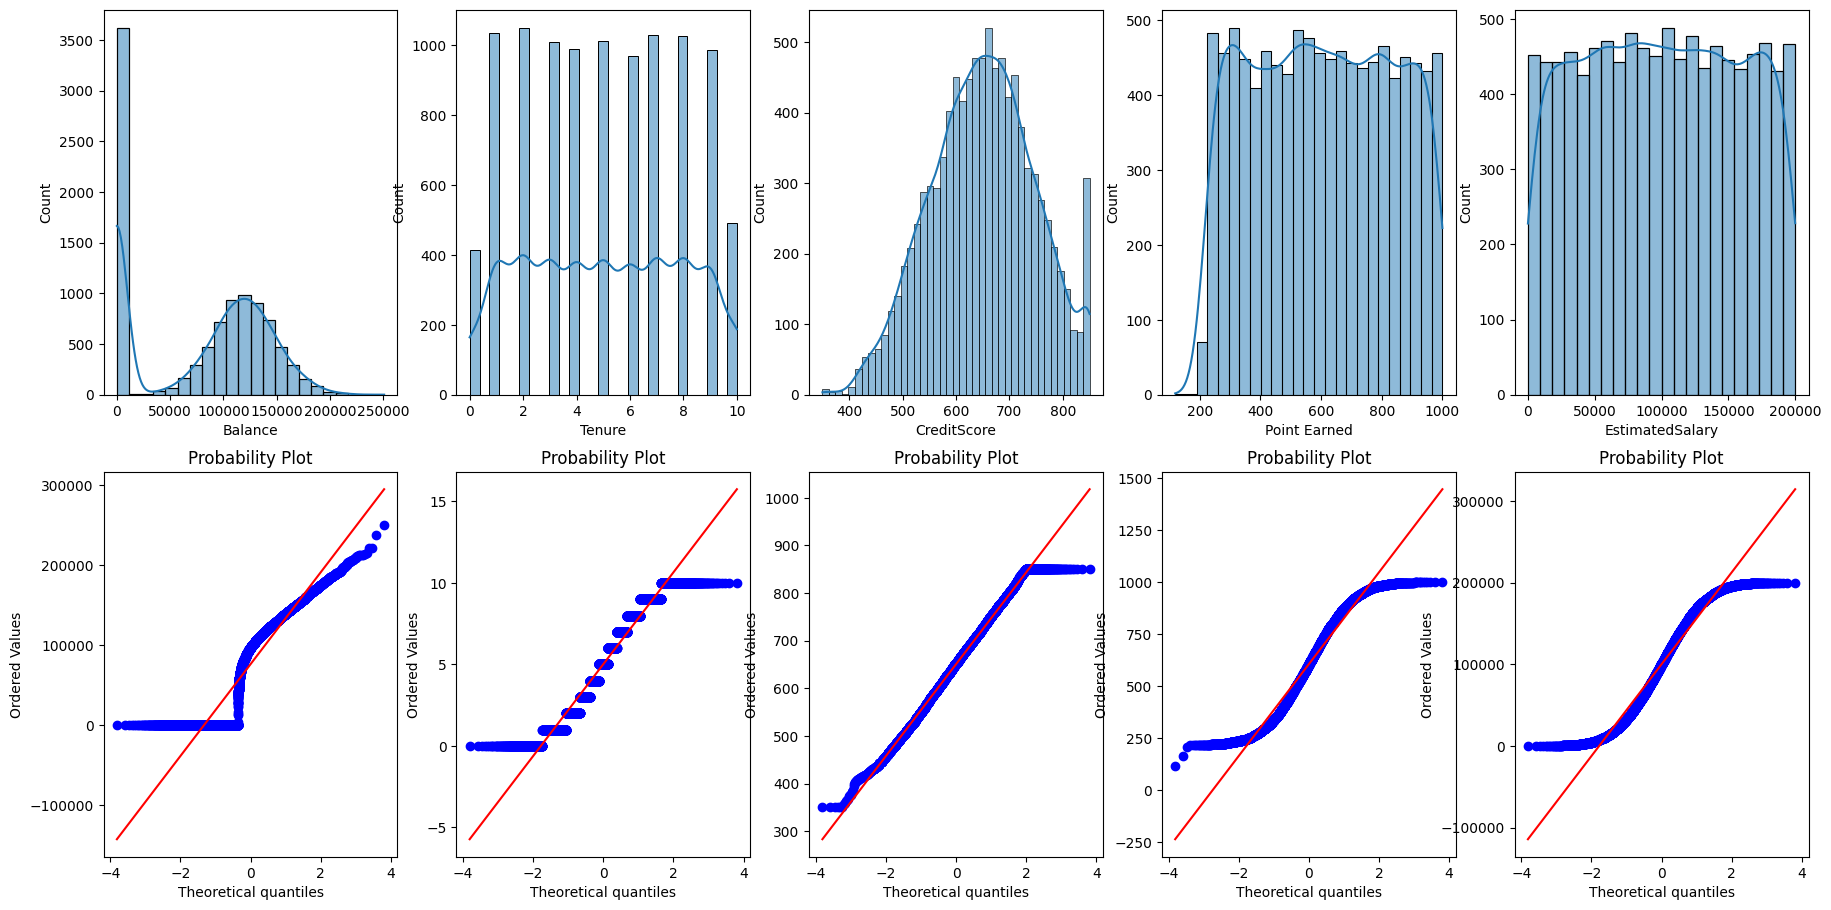

In [408]:
plot , ax = plt.subplots(2 , 5 , figsize = (22 , 11))
g = sns.histplot(cust['Balance'] , kde = True , ax = ax[0][0])
res = stats.probplot(cust['Balance'], plot= ax[1][0])
g = sns.histplot(cust['Tenure'] , kde = True , ax = ax[0][1])
res = stats.probplot(cust['Tenure'], plot= ax[1][1])
g = sns.histplot(cust['CreditScore'] , kde = True , ax = ax[0][2])
res = stats.probplot(cust['CreditScore'], plot= ax[1][2])
g = sns.histplot(cust['Point Earned'] , kde = True , ax = ax[0][3])
res = stats.probplot(cust['Point Earned'], plot= ax[1][3])
g = sns.histplot(cust['EstimatedSalary'] , kde = True , ax = ax[0][4])
res = stats.probplot(cust['EstimatedSalary'], plot= ax[1][4])

Observation: 
- Balance is following **edge peak distribution** with peak at 0.
- Tenure, Point Earned and EstimatedSalary have a **uniform distribution**.
- CreditScore shows **left skewed distribution** with tail on the right.

These numerical variables are not following a normal distribution. These distributions indicate there are different data distributions present in population data with separate and independent peaks.

Action :

- Check if the target variable represents the different distribution present in the data due to presence of different classes.
- Data scaling, As most of the algorithms assume the data to be normally (Gaussian) distributed we can do one of the following:

Normalization : Carried for features whose data does not display normal distribution.
Standardization : Carried out for features that are normally distributed where their values are huge or very small as compared to other features.

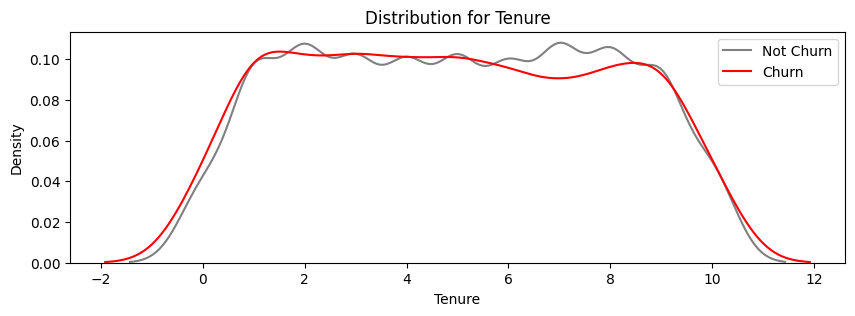

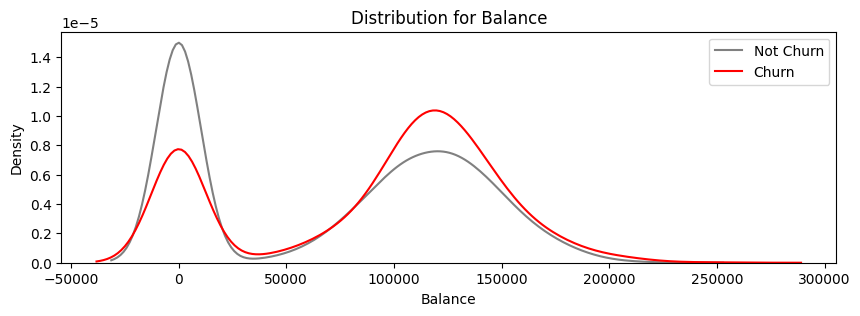

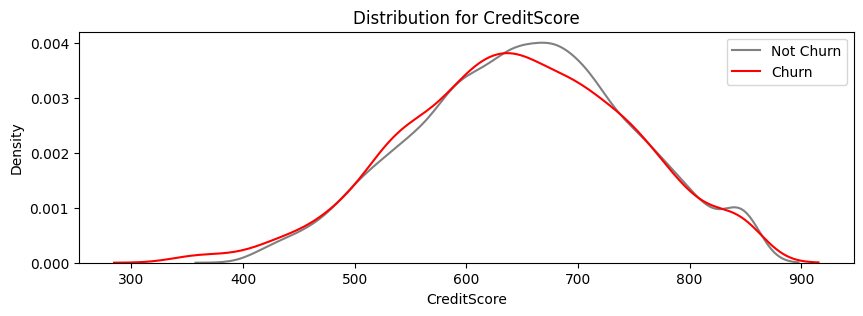

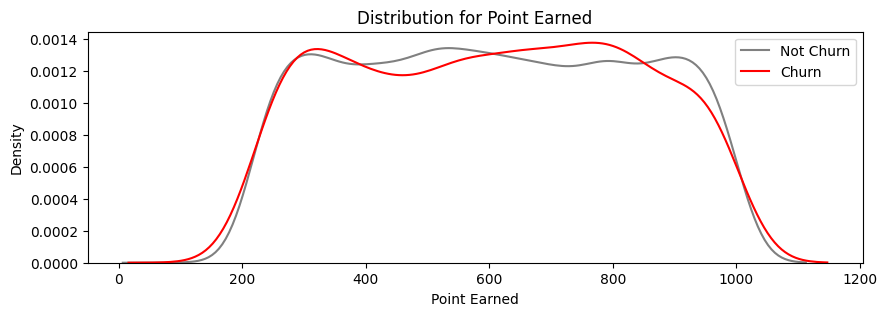

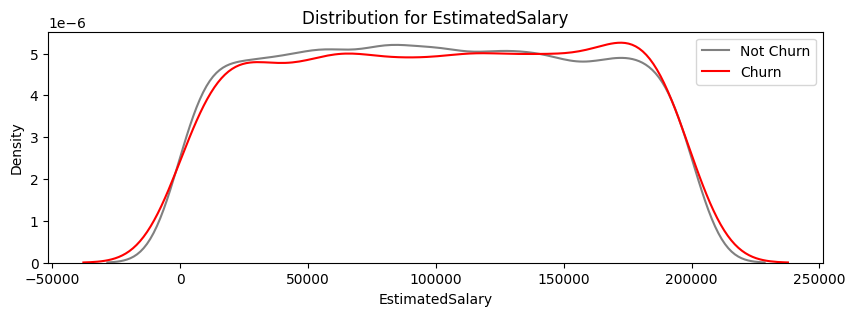

In [409]:
def kdeplot(feature):
    plt.figure(figsize=(10, 3))
    plt.title("Distribution for {}".format(feature))
    ax0 = sns.kdeplot(cust[cust['Churn'] == 0][feature].dropna(), color= 'grey', label= 'Churn: No')
    ax1 = sns.kdeplot(cust[cust['Churn'] == 1][feature].dropna(), color= 'Red', label= 'Churn: Yes')
    ax0.legend(["Not Churn","Churn"],loc='upper right')
    
kdeplot('Tenure')
kdeplot('Balance')
kdeplot('CreditScore')
kdeplot('Point Earned')
kdeplot('EstimatedSalary')

- **Churn by Tenure** : Clients with 8-10 years are less likely to churn
- **Churn by Balance** : Surprisingly clients with balance in range 100000-150000 are more likely to exit
- **Churn by CreditScore** : It seems that CreditScore doesnt have much affect on churn
- **Churn by Point Earned** : Clients with high Points Earned are more likely to churn
- **Churn by EstimatedSalary** : Customers with higher Estimated Salary are more likely to churn

#### Normalization

In [410]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization

cust['Tenure'] = mms.fit_transform(cust[['Tenure']])
cust['Balance'] = mms.fit_transform(cust[['Balance']])
cust['CreditScore'] = mms.fit_transform(cust[['CreditScore']])
cust['Point Earned'] = mms.fit_transform(cust[['Point Earned']])
cust['EstimatedSalary'] = mms.fit_transform(cust[['EstimatedSalary']])


<Axes: >

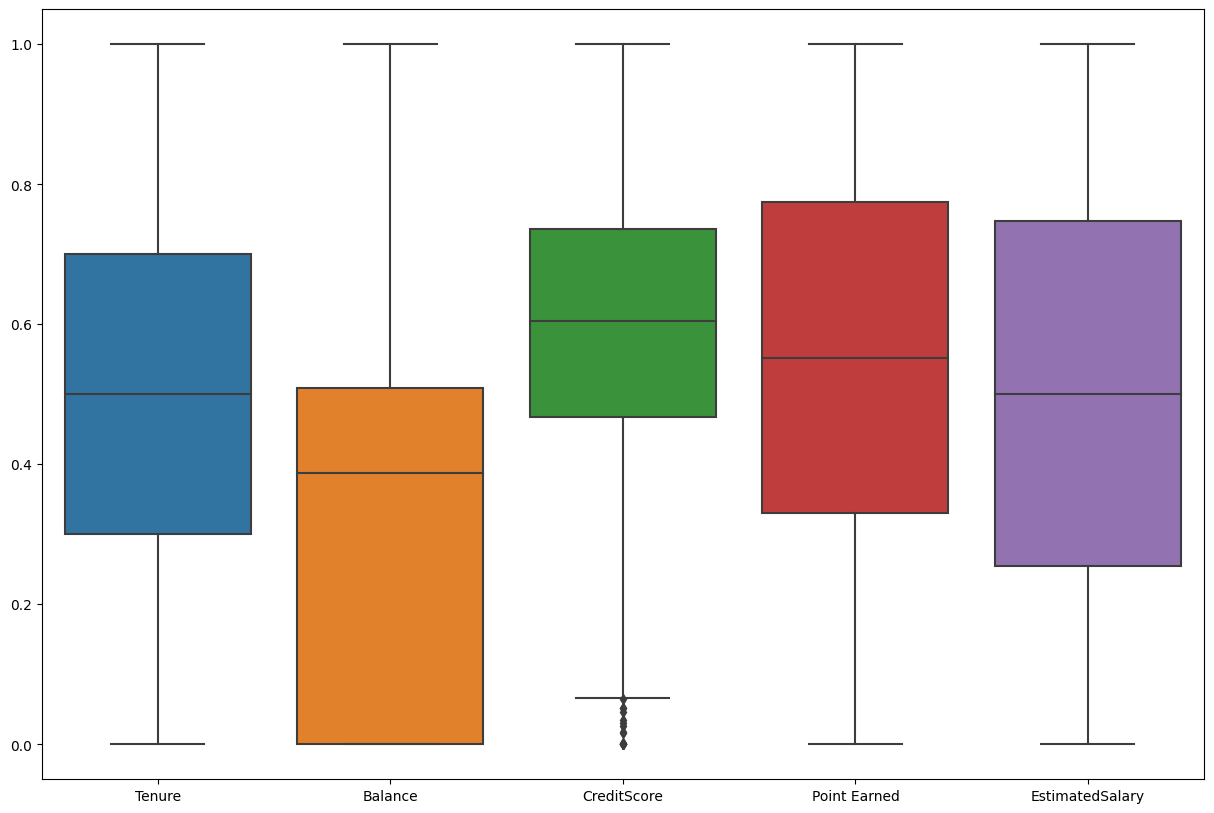

In [411]:
plt.figure(figsize=(15,10))
sns.boxplot(data=cust[['Tenure','Balance','CreditScore', 'Point Earned', 'EstimatedSalary']])

#### c. Analyzing Categorical Values

In [412]:
df_cust=cust.copy()

Text(0.5, 1.0, 'Distribution of Churned Customer by Age')

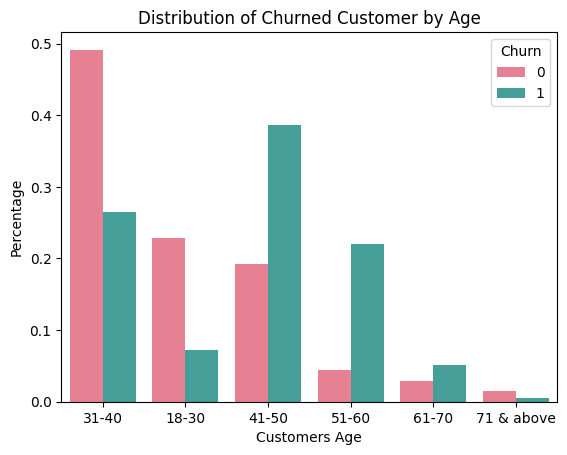

In [413]:

age_groups = {(18, 30): "18-30",(31, 40): "31-40",(41, 50): "41-50",(51, 60): "51-60",(61, 70): "61-70",(71, float("inf")):"71 & above"}

# Create a new column for age groups
df_cust['Age Group'] = df_cust['Age'].apply(lambda x: next((v for k, v in age_groups.items() if k[0] <= x <= k[1]), None))

# Create group data frame
data = df_cust.groupby("Churn")["Age Group"].value_counts(normalize=True).rename("Percentage").reset_index()

# # Plot a bar chart

sns.barplot(x="Age Group", y="Percentage", hue="Churn",palette="husl", data=data)
plt.xlabel('Customers Age')
plt.ylabel("Percentage")
plt.title('Distribution of Churned Customer by Age')

- **Churn by Age** : Older customers are more likely to churn rather than younger customers.

Text(0.5, 1.0, 'Distribution of Churn by Card Type')

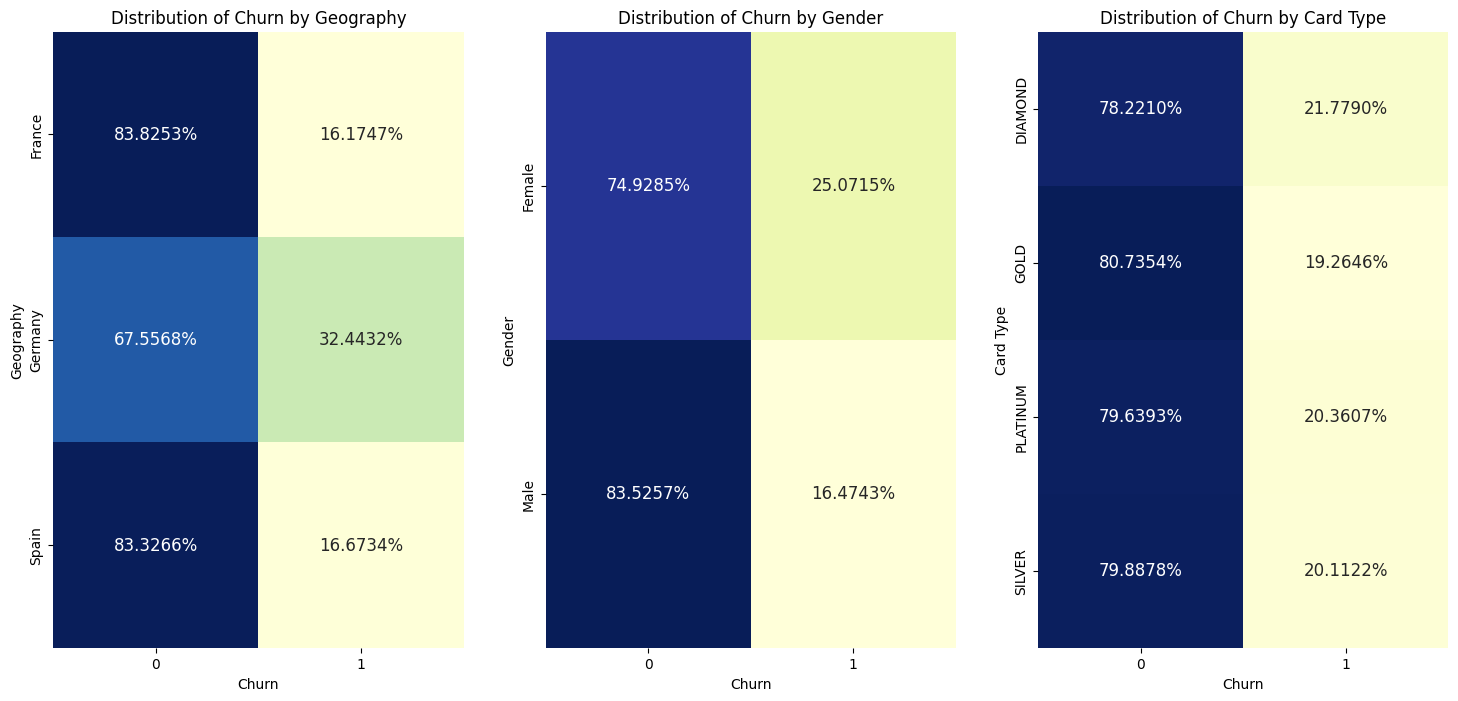

In [414]:
plot , ax = plt.subplots(1 , 3 , figsize = (18 , 8))
cross_tab = pd.crosstab(cust.Geography , cust.Churn , normalize='index')
sns.heatmap(cross_tab, annot = True , fmt = '0.4%' , cbar = False , annot_kws = {"size":12}, cmap = "YlGnBu",ax=ax[0])
ax[0].set_title("Distribution of Churn by Geography")
cross_tab=pd.crosstab(cust.Gender.map({0:"Female",1:"Male"}), cust.Churn, normalize = 'index')
sns.heatmap(cross_tab, annot= True , fmt = '0.4%' , cbar = False , annot_kws = {"size":12}, cmap = "YlGnBu", ax = ax[1])
ax[1].set_title("Distribution of Churn by Gender")
cross_tab=pd.crosstab(cust['Card Type'], cust.Churn, normalize = 'index')
sns.heatmap(cross_tab, annot= True , fmt = '0.4%' , cbar = False , annot_kws = {"size":12}, cmap = "YlGnBu", ax = ax[2])
ax[2].set_title("Distribution of Churn by Card Type")

- **Churn by Geography** : Customers in Germany have the hightest churn rate compared to Spain & France
- **Churn by Gender** : Female customers are more likely to exit
- **Churn by Card Type** : Card type individually doesnt have much effect on Churn Rate

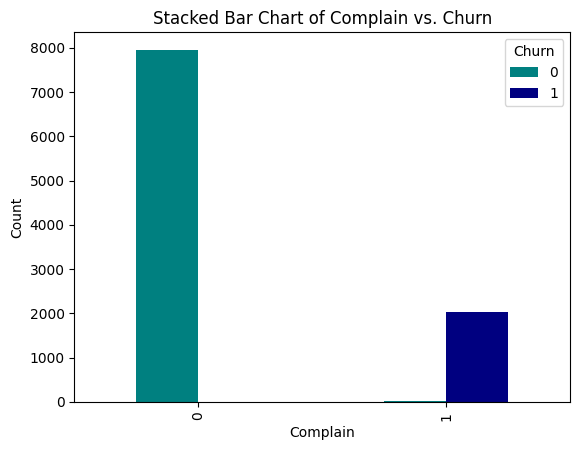

In [415]:
# Create a stacked bar chart
df_grouped = cust.groupby(['Complain', 'Churn']).size().unstack()
df_grouped.plot(kind='bar', stacked=False, color={0:"#008080",1:"#000080"})

# Add labels and title
plt.xlabel('Complain')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Complain vs. Churn')

# Show the plot
plt.show()

- **Churn by Complain** : We can see that almost all the customers with complains have exited

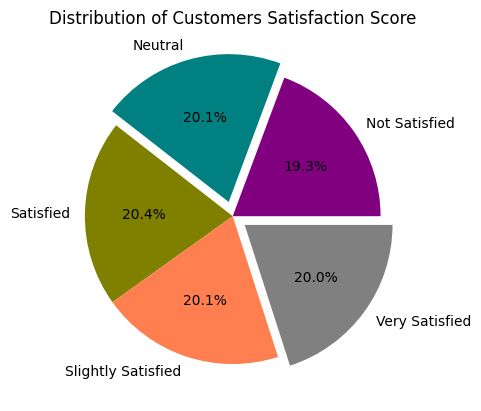

In [416]:
# Sample data (replace with your actual data)
data = cust["Satisfaction Score"]

# Define the labels based on your mapping
labels = {
    1: 'Not Satisfied',
    2: 'Neutral',
    3: 'Satisfied',
    4: 'Slightly Satisfied',
    5: 'Very Satisfied'
}

# Create a list of labels based on your data
mapped_labels = [labels[value] for value in data]


# Count the occurrences of each mapped label
label_counts = [mapped_labels.count(label) for label in labels.values()]

# Define other parameters
explode = [0, 0.1, 0, 0, 0.1]
colors = ("purple", "teal", "olive", "coral", "grey")

# Create the pie chart
plt.pie(label_counts, labels=labels.values(), explode=explode, colors=colors, autopct="%.1f%%")

plt.title("Distribution of Customers Satisfaction Score")
plt.show()


All these values are biased and show no specific distribution 

**Observation** :

No direct relation observed between the following features and the target variable:
- Satisfaction Scorea
- Card Type
- CreditScore
- EstimatedSalary

We can drop these columns

##### d. Multicolinearity among predictors

In [417]:
cust_imp = cust.drop(columns=["Satisfaction Score", "Card Type","CreditScore","EstimatedSalary","Churn"])

# Define the mapping
gender_mapping = {0: 'Female', 1: 'Male'}

# Apply the mapping to the "Gender" column
cust_imp['Gender'] = cust_imp['Gender'].map(gender_mapping)

# Define the mapping
NumProduct_mapping = {0: 'zero', 1: 'one', 2:'two',3:'three',4:'four'}

# Apply the mapping to the "Gender" column
cust_imp['NumOfProducts'] = cust_imp['NumOfProducts'].map(NumProduct_mapping)

Churn = cust["Churn"]
pred = pd.get_dummies(cust_imp)

<Axes: >

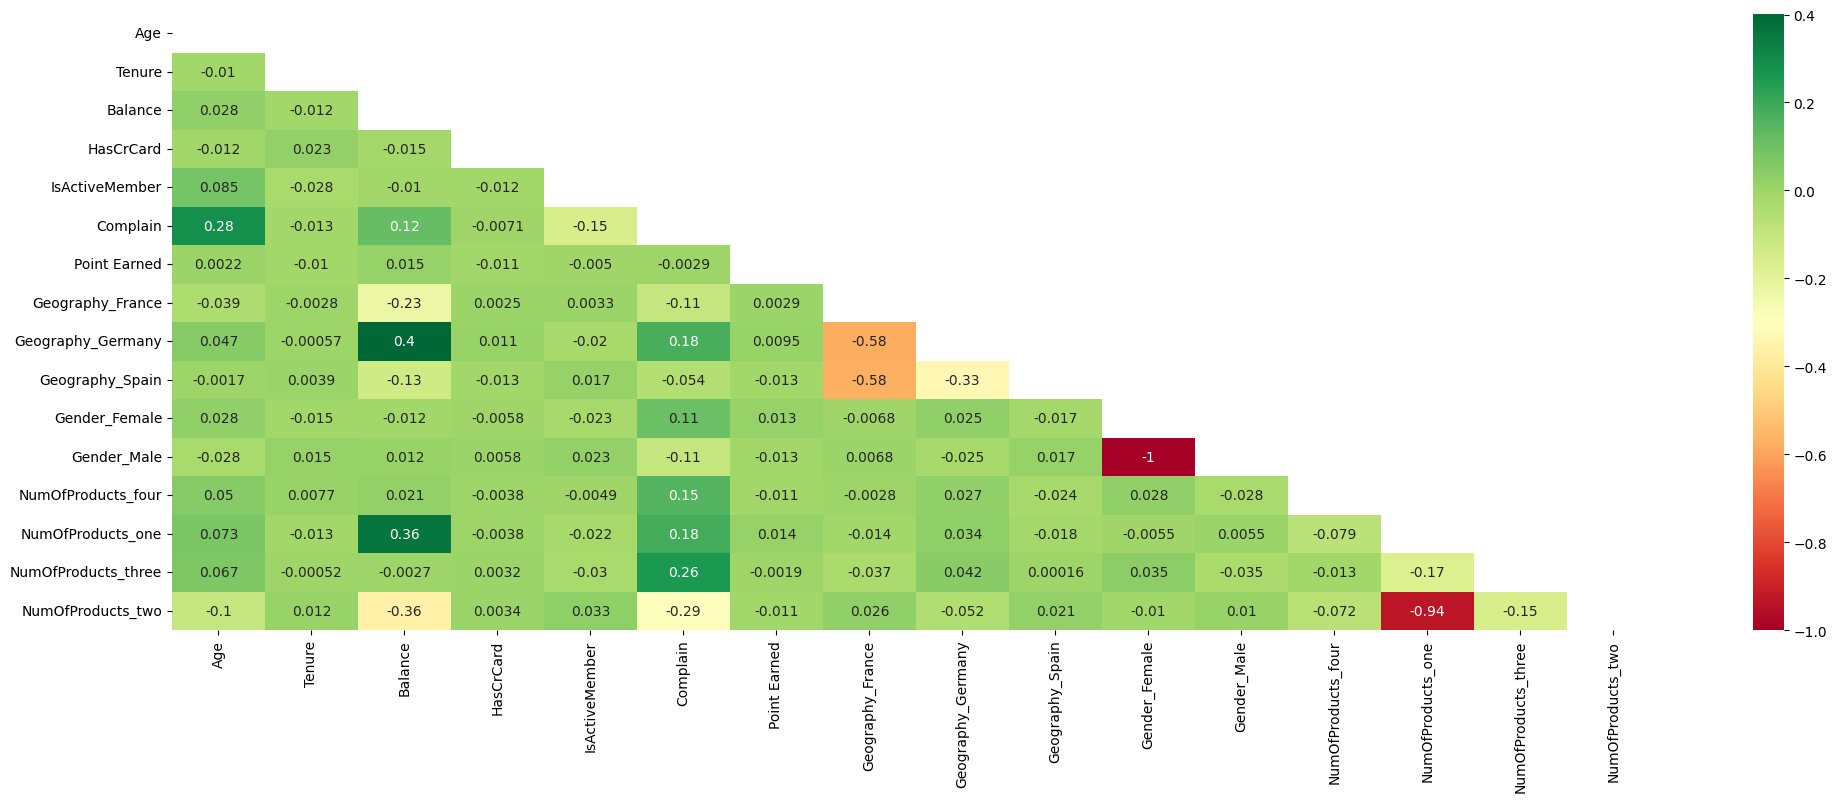

In [418]:
#the heat map of the correlation
plt.figure(figsize=(24,8))
corr = pred.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn')

**Observation** : 
- Geography_France, Geography_Spain and Geography_Germany are highly corelated to each other.
- HasCrCard has very less correlation with any of the variables.

**Action**: Dropping some of the highly correlated categorical variables.

In [419]:
pred.drop(columns=["Geography_Germany","Geography_Spain","HasCrCard","Gender_Male","NumOfProducts_one", "NumOfProducts_two"],inplace=True)

### e. OLS Regression

**Ordinary Least Squares regression (OLS)** is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable (simple or multiple linear regression).

In [420]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(Churn, pred).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Churn   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.454e+05
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                        0.00
Time:                        01:48:59   Log-Likelihood:                          18700.
No. Observations:               10000   AIC:                                 -3.738e+04
Df Residuals:                    9990   BIC:                                 -3.731e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0001   2.71e-05      4.281      0.000    6.29e-05       0.000
Tenure                 -0.0015      0.001     -1.226      0.220      -0.004       0.001
Balance             -8.838e-05      0.001     -0.059      0.953      -0.003       0.003
IsActiveMember         -0.0024      0.001     -3.204      0.001      -0.004      -0.001
Complain                0.9925      0.001    959.002      0.000       0.991       0.995
Point Earned           -0.0034      0.001     -2.524      0.012      -0.006      -0.001
Geography_France        0.0002      0.001      0.251      0.802      -0.001       0.002
Gender_Female           0.0002      0.001      0.294      0.769      -0.001       0.002
NumOfProducts_four      0.0056      0.005      1.153      0.249      -0.004       0.015
NumOfProducts_three     0.0046      0.002      1.914      0.056      -0.000       0.009
==============================================================================
Omnibus:                    17391.198   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        205524068.590
Skew:                         -11.197   Prob(JB):                         0.00
Kurtosis:                     704.966   Cond. No.                         530.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation** : NumOfProducts and IsActiveMember look significant as well.

#### f. Data Balancing

In order to cope with unbalanced data, we will be performing Oversampling, i.e. increase the minority samples of the target variable to the majority samples. For data balancing, we will use imblearn.

The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [421]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [422]:
over = SMOTE(sampling_strategy = 1)

X = pred.values
y = Churn.values

X, y = over.fit_resample(X, y)
Counter(y)

Counter({1: 7962, 0: 7962})

In [423]:
pred

Age  Tenure   Balance  IsActiveMember  Complain  Point Earned  \
0      42     0.2  0.000000               1         1      0.391600   
1      41     0.1  0.334031               1         1      0.382520   
2      42     0.8  0.636357               0         1      0.292849   
3      39     0.1  0.000000               0         0      0.262202   
4      43     0.2  0.500246               1         0      0.347333   
...   ...     ...       ...             ...       ...           ...   
9995   39     0.5  0.000000               0         0      0.205448   
9996   35     1.0  0.228657               1         0      0.740068   
9997   36     0.7  0.000000               1         1      0.505108   
9998   42     0.3  0.299226               0         1      0.249716   
9999   28     0.4  0.518708               0         0      0.898978   

      Geography_France  Gender_Female  NumOfProducts_four  NumOfProducts_three  
0                    1              1                   0                    0  
1                    0              1                   0                    0  
2                    1              1                   0                    1  
3                    1              1                   0                    0  
4                    0              1                   0                    0  
...                ...            ...                 ...                  ...  
9995                 1              0                   0                    0  
9996                 1              0                   0                    0  
9997                 1              1                   0                    0  
9998                 0              0                   0                    0  
9999                 1              1                   0                    0  

[10000 rows x 10 columns]

# 4.Modeling

In [424]:
##Importing the libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)


In [426]:
# Defining the Classification Model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Add this import at the beginning of your code

# Modify your `model` function
def model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    
    print("Cross Validation Score: ", '{0:.2%}'.format(cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc').mean()))
    print("ROC AUC Score: ", '{0:.2%}'.format(roc_auc))
    
    # Plot the ROC AUC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()


# Defining Evaluation Metrics
def model_evaluation(classifier,X_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(X_test)))


### Hyperparameter tuning using Optuna
Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

In [427]:
import lightgbm as lgb
import optuna
import sklearn
def objective(trial):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
    dtrain = lgb.Dataset(X_train, label=y_train)

#     param = {
#             "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "n_estimators": 1000,
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.02]),
#         'max_depth': trial.suggest_categorical('max_depth', [10, 20, 100]),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
#         'cat_smooth': trial.suggest_int('min_data_per_groups', 1, 100)
#     }
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.006, 0.02),
        'max_depth': trial.suggest_int('max_depth', 10, 100, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth': trial.suggest_int('cat_smooth', 1, 100)
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy


In [428]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2023-10-16 01:48:59,705] A new study created in memory with name: no-name-0eb17b73-617e-4b56-acd8-eb236179fb67
C:\Users\Shubham Idekar\AppData\Local\Temp\ipykernel_19040\3329667105.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
C:\Users\Shubham Idekar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-10-16 01:49:00,690] Trial 0 finished with value: 0.9992464204973625 and parameters: {'reg_alpha': 5.36536426502907, 'reg_lambda': 3.5051379511907212, 'colsample_bytree': 0.9, 'subsample': 0.6241422973980659, 'learning_rate': 0.010608697761342649, 'max_depth': 58, 'num_leaves': 30, 'min_child

[I 2023-10-16 01:49:05,306] Trial 8 finished with value: 0.9989952273298166 and parameters: {'reg_alpha': 2.070892596551935, 'reg_lambda': 8.587629538713923, 'colsample_bytree': 0.7, 'subsample': 0.7816861324671454, 'learning_rate': 0.014545237896772934, 'max_depth': 36, 'num_leaves': 37, 'min_child_samples': 242, 'cat_smooth': 77}. Best is trial 7 with value: 0.9987440341622708.
C:\Users\Shubham Idekar\AppData\Local\Temp\ipykernel_19040\3329667105.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
C:\Users\Shubham Idekar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-10-16 01:49:05,779] Tri

[I 2023-10-16 01:49:09,330] Trial 17 finished with value: 0.9994976136649083 and parameters: {'reg_alpha': 9.970827349933646, 'reg_lambda': 4.80433152375143, 'colsample_bytree': 0.3, 'subsample': 0.5739133208679117, 'learning_rate': 0.016380767263675003, 'max_depth': 20, 'num_leaves': 90, 'min_child_samples': 116, 'cat_smooth': 59}. Best is trial 10 with value: 0.9984928409947249.
C:\Users\Shubham Idekar\AppData\Local\Temp\ipykernel_19040\3329667105.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
C:\Users\Shubham Idekar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-10-16 01:49:09,667] Tr

In [429]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 20
Best trial:
  Value: 0.9984928409947249
  Params: 
    reg_alpha: 9.265085082531986
    reg_lambda: 5.759228177898758
    colsample_bytree: 0.8
    subsample: 0.7587626428734962
    learning_rate: 0.019839859980754253
    max_depth: 19
    num_leaves: 92
    min_child_samples: 286
    cat_smooth: 98


In [430]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

classifier_lgbm = LGBMClassifier(
   n_estimators=1000,
    reg_alpha=9.265085082531986,
    reg_lambda=5.759228177898758,
    colsample_bytree=0.8,
    subsample=0.7587626428734962,
    learning_rate=0.019839859980754253,
    max_depth=19,  # Adjust max_depth
    num_leaves=92,  # Adjust num_leaves
    min_child_samples=286,  # Adjust min_child_samples
    cat_smooth=98,
    force_col_wise=True
)

[LightGBM] [Info] Number of positive: 6742, number of negative: 6793
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 13535, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498116 -> initscore=-0.007536
[LightGBM] [Info] Start training from score -0.007536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Info] Number of positive: 6067, number of negative: 6114
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 12181, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498071 -> initscore=-0.007717
[LightGBM] [Info] Start training from score -0.007717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 6068, number of negative: 6113
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 12181, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498153 -> initscore=-0.007389
[LightGBM] [Info] Start training from score -0.007389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 6068, number of negative: 6114
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 12182, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498112 -> initscore=-0.007552
[LightGBM] [Info] Start training from score -0.007552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 6068, number of negative: 6113
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Number of data points in the train set: 12181, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498153 -> initscore=-0.007389
[LightGBM] [Info] Start training from score -0.007389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 6068, number of negative: 6114
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 12182, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498112 -> initscore=-0.007552
[LightGBM] [Info] Start training from score -0.007552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

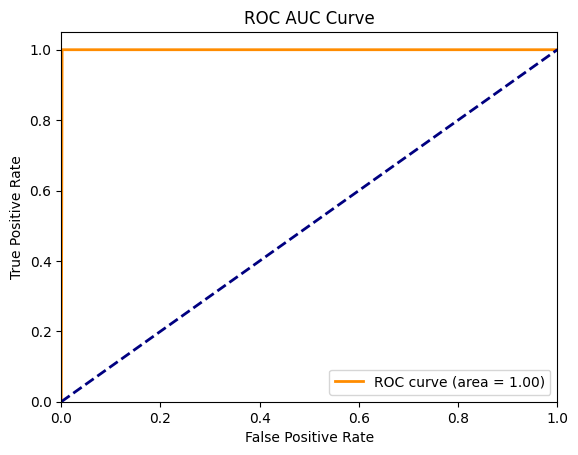

In [431]:
model(classifier_lgbm,X_train,y_train,X_test,y_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1169
           1       1.00      1.00      1.00      1220

    accuracy                           1.00      2389
   macro avg       1.00      1.00      1.00      2389
weighted avg       1.00      1.00      1.00      2389



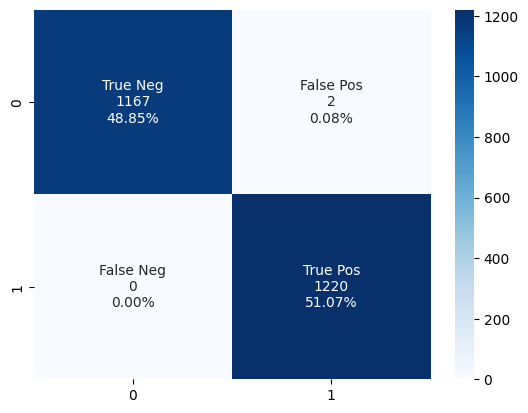

In [432]:
model_evaluation(classifier_lgbm,X_test,y_test)


### Model Evaluation
Let's understand what is meant by Precision and Recall.

- Precision measures the percentage of customers predicted by us to Churn that were correctly classified.
- Recall measures the percentage of actual customers that churned were correctly classified.

When we predict that the customers will churn, 51% of customers actually churned. Whereas, out of all the customers that churned we were able to capture 50% of all them correctly.

We can further tune our models to be more precise or have a better recall based on the business requirement.